# Import Libraries

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns                                 # For enhanced plotting style

import yfinance as yf                                 #for downloading data from yahoo fianance
from sklearn.preprocessing import MinMaxScaler        # For scaling data
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from datetime import datetime,timedelta

sns.set_style("whitegrid")                            # Set seaborn plot background
plt.style.use("fivethirtyeight")
%matplotlib inline



# Download Stock Data (Live using yfinance)

In [74]:
stock_symbol = 'AMZN'  # Change this to any valid stock on Yahoo finance
start_date = '2010-01-01'  
end_date = datetime.today().strftime('%Y-%m-%d')

# Download data of selected stock
df = yf.download(stock_symbol, start=start_date, end=end_date)

# Display first 10 rows
df.head(10)

/var/folders/36/bvwn4n457ysfdjlhbxrjsknh0000gn/T/ipykernel_48381/2048424580.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,
2010-01-04,6.6950,6.8305,6.6570,6.8125,151998000
2010-01-05,6.7345,6.7740,6.5905,6.6715,177038000
2010-01-06,6.6125,6.7365,6.5825,6.7300,143576000
2010-01-07,6.5000,6.6160,6.4400,6.6005,220604000
2010-01-08,6.6760,6.6840,6.4515,6.5280,196610000
2010-01-11,6.5155,6.6400,6.4605,6.6310,175588000
2010-01-12,6.3675,6.4910,6.3275,6.4495,181926000
2010-01-13,6.4555,6.4855,6.2875,6.3950,214464000


# 1. Stock Trend over time

### Stock Price

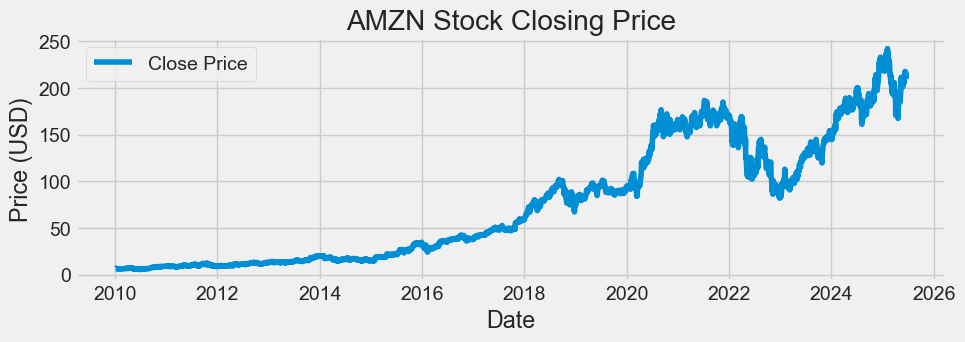

In [87]:
#plotting Stock closing price Graph
plt.figure(figsize=(14, 3))
sns.lineplot(x=df.index, y=df['Close'].squeeze(), label='Close Price')
plt.title(f"{stock_symbol} Stock Closing Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

###  Volume Trend Plot

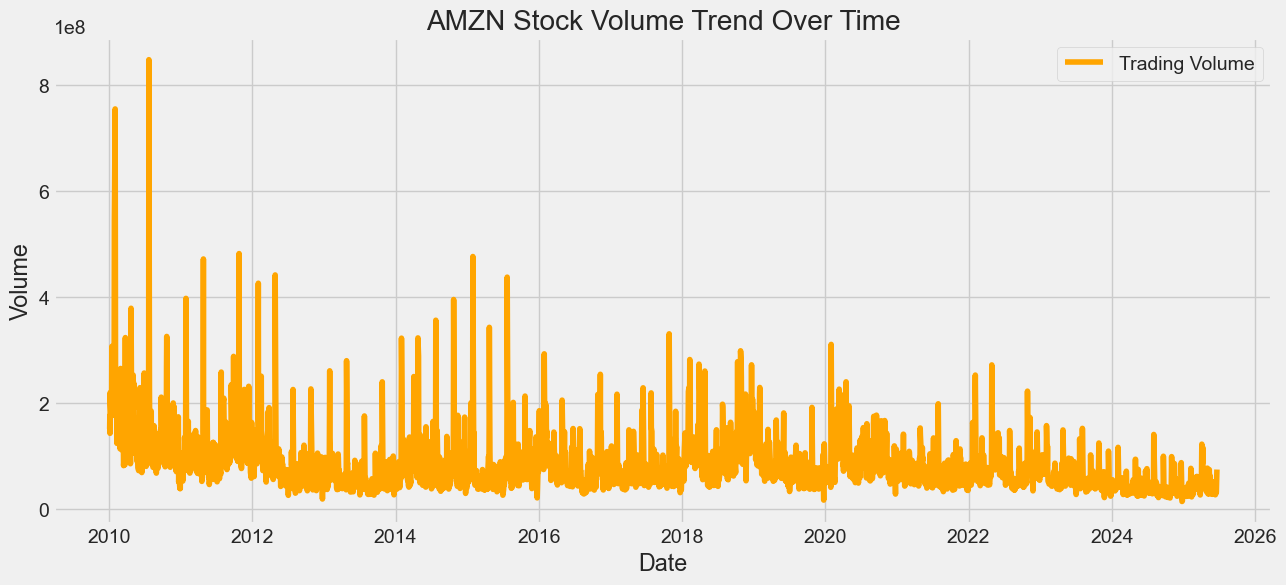

In [76]:
#plotting Stock Volume Trend Graph
plt.figure(figsize=(14, 6))
sns.lineplot(x=df.index, y=df['Volume'].squeeze(), label='Trading Volume', color='orange')
plt.title(f"{stock_symbol} Stock Volume Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.show()


## Descriptive data

In [77]:
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
count,3890.000000,3890.000000,3890.000000,3890.000000,3.890000e+03
mean,75.483055,76.365805,74.547407,75.494824,8.206833e+07
std,64.539381,65.307813,63.739020,64.558843,5.142715e+07
min,5.430500,5.564500,5.290000,5.296500,1.500750e+07
25%,15.251750,15.381875,15.075250,15.218000,5.143662e+07
50%,50.039001,50.405251,49.779751,50.123499,6.893400e+07
75%,129.099995,131.055504,127.445002,129.492500,9.758800e+07
max,242.059998,242.520004,238.029999,239.020004,8.484220e+08


# 2. Daily Returns

#### Year to Year Return

/var/folders/36/bvwn4n457ysfdjlhbxrjsknh0000gn/T/ipykernel_48381/2269527313.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_close = df['Close'].resample('Y').last()


<Figure size 1200x600 with 0 Axes>

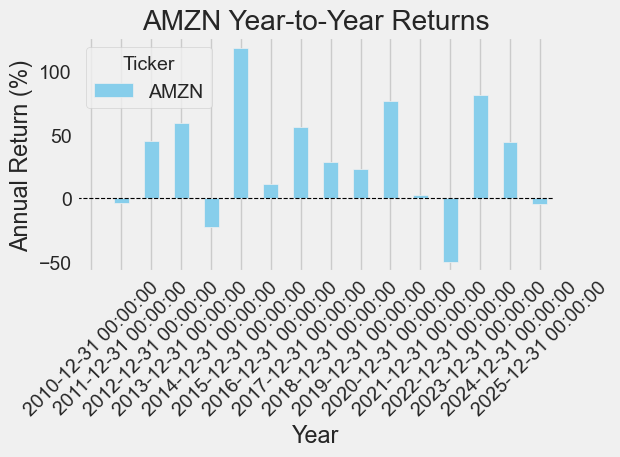

In [78]:
# Resample to get the last closing price of each year to compare year to year return
yearly_close = df['Close'].resample('Y').last()

# Calculate year-over-year return in percentage
annual_return = yearly_close.pct_change() * 100

# Plot the results
plt.figure(figsize=(12, 6))
annual_return.plot(kind='bar', color='skyblue')
plt.title(f'{stock_symbol} Year-to-Year Returns')
plt.ylabel('Annual Return (%)')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.grid(axis='y')
plt.tight_layout()
plt.show()




#### Distribution of Return

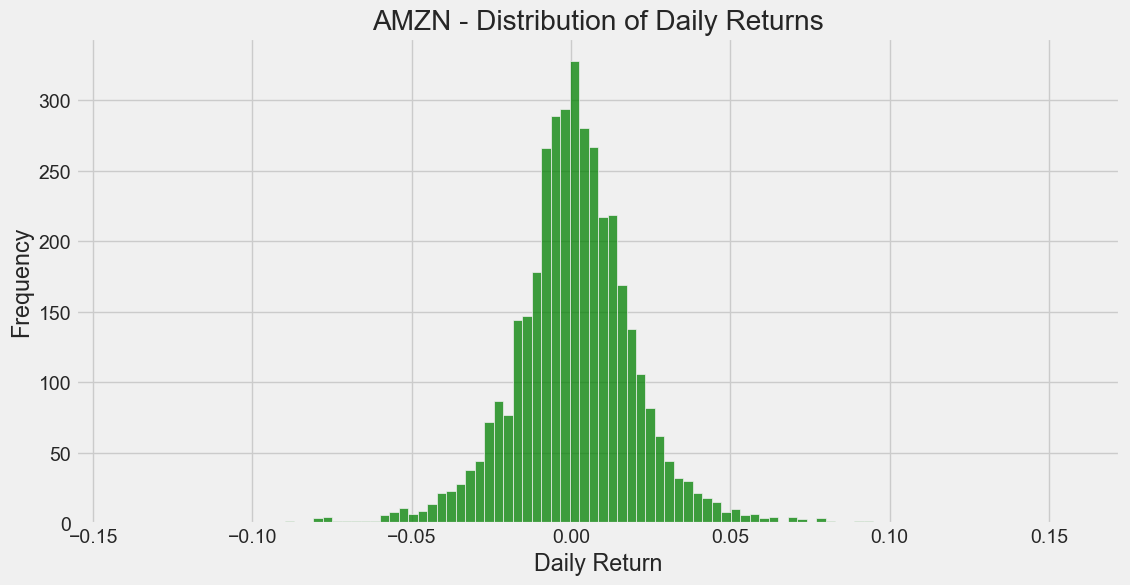

Average Daily Return: 0.0011002267787852224


In [79]:
# Calculate daily percentage change in the 'Close' price
df['Daily Return'] = df['Close'].pct_change()

# Plot histogram of daily returns
plt.figure(figsize=(12,6))
sns.histplot(df['Daily Return'].dropna(), bins=100, color='green')
plt.title(f"{stock_symbol} - Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()

# Print average daily return
print("Average Daily Return:", df['Daily Return'].mean())


#  3. Predicting the Closing price

### Data Preprocessing

In [80]:
# Use all columns to train data
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

# Scale all features
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

# For LSTM (single-step prediction)

sequence_length = 60  # Number of past days used for prediction

X, y = [], []

# Create sequences for LSTM
for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i])  # Past 60 days of features
    y.append(data_scaled[i][3])                # Target: 'Close' price (column index 3)

# Convert lists to NumPy arrays
X, y = np.array(X), np.array(y)


# Split both datasets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

split_seq = int(0.8 * len(X_seq))
X_train_seq, X_test_seq = X_seq[:split_seq], X_seq[split_seq:]
y_train_seq, y_test_seq = y_seq[:split_seq], y_seq[split_seq:]


### Training the Model to perdict

In [81]:
# --- LSTM using all features ---
# --- Build LSTM Model ---
model_lstm = Sequential([
    # First LSTM layer (returns sequences for stacking)
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    
    # Second LSTM layer (does not return sequences)
    LSTM(50),
    
    # Output layer with 1 neuron for predicting 'Close' price
    Dense(1)
])
#Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0021
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.4501e-04
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.2453e-04
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.9511e-04
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.3131e-04
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.1371e-04
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.4417e-04
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.2340e-04
Epoch 9/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.2538e-04
Epoch 10/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.3339e-04
Epoch 11/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.1498e-04
Epoch 12/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.0685e-04
Epoch 13/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.4417e-04
Epoch 14/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.9195e-05
Epoch 15/20
96/96 ━━━━━━━━━━━━

### Comparing actual vs perdicted result for test data

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


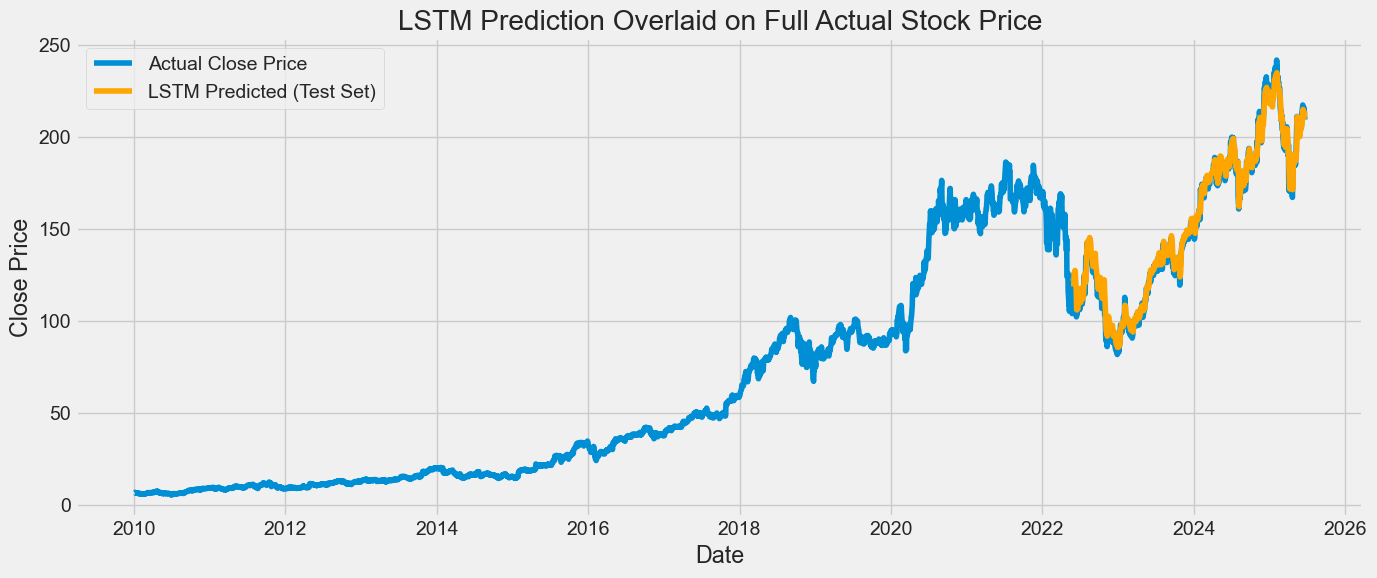

In [82]:
# Predict using the LSTM model
y_pred = model_lstm.predict(X_test)

# Ensure both y_pred and y_test are same length
min_len = min(len(y_pred), len(y_test))
y_pred = y_pred[:min_len]
y_test_trimmed = y_test[:min_len]

# Inverse scale predicted values 
dummy_pred = np.zeros((min_len, 5))  # Assuming 5 features
dummy_pred[:, 3] = y_pred.flatten()  # 3 = Close column
y_pred_scaled = scaler.inverse_transform(dummy_pred)[:, 3]

# Inverse scale actual y_test values
dummy_actual = np.zeros((min_len, 5))
dummy_actual[:, 3] = y_test_trimmed.flatten()
y_test_scaled = scaler.inverse_transform(dummy_actual)[:, 3]

#Inverse scale full Close column 
scaled_close_full = scaler.transform(df)[:, 3]
dummy_full = np.zeros((len(df), 5))
dummy_full[:, 3] = scaled_close_full
close_actual_full = scaler.inverse_transform(dummy_full)[:, 3]

# Create full-length predicted array for plotting 
predicted_full = np.full_like(close_actual_full, np.nan)
predicted_full[-len(y_pred_scaled):] = y_pred_scaled

#Plot Actual vs LSTM Predicted
plt.figure(figsize=(14, 6))
plt.plot(df.index, close_actual_full, label='Actual Close Price')
plt.plot(df.index, predicted_full, label='LSTM Predicted (Test Set)', color='orange')
plt.title('LSTM Prediction Overlaid on Full Actual Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Error

In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Ensure equal lengths just in case
min_len_lstm = min(len(y_test_scaled), len(y_pred_scaled))
y_true_lstm = y_test_scaled[:min_len_lstm]
y_pred_lstm = y_pred_scaled[:min_len_lstm]

# Compute Metrics for LSTM
mse_lstm = mean_squared_error(y_true_lstm, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_true_lstm, y_pred_lstm)
r2_lstm = r2_score(y_true_lstm, y_pred_lstm)

# Print Results
print("\n📊 LSTM Model Accuracy:")
print(f"MSE  : {mse_lstm:.4f}")
print(f"RMSE : {rmse_lstm:.4f}")
print(f"MAE  : {mae_lstm:.4f}")
print(f"R²   : {r2_lstm:.4f}")



📊 LSTM Model Accuracy:
MSE  : 16.9213
RMSE : 4.1135
MAE  : 3.1450
R²   : 0.9902


### Future Prediction

In [84]:
import numpy as np
import pandas as pd

# Parameters
n_past = 60      # Number of days used in input sequence
n_future = 50    # Number of future days to predict

# Prepare scaled data
df_values = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
df_scaled = scaler.transform(df_values)

# Start with last n_past days
last_sequence = df_scaled[-n_past:].copy()
predicted = []

#Predict one day at a time
for _ in range(n_future):
    input_seq = last_sequence.reshape(1, n_past, 5)
    pred_scaled = model_lstm.predict(input_seq, verbose=0)[0][0]

    # Inverse transform only the 'Close' column
    dummy = np.zeros((1, 5))
    dummy[0, 3] = pred_scaled
    pred_actual = scaler.inverse_transform(dummy)[0, 3]
    predicted.append(pred_actual)

    # Update the sequence with the new prediction
    new_entry = last_sequence[-1].copy()
    new_entry[3] = pred_scaled
    last_sequence = np.vstack([last_sequence[1:], new_entry])

# Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future, freq='B')

# Print predicted prices
print(f"\n📈 LSTM Forecast for the Next {n_future} Business Days:\n")
for date, price in zip(future_dates, predicted):
    print(f"{date.strftime('%Y-%m-%d')} : ₹{price:.2f}")



📈 LSTM Forecast for the Next 50 Business Days:

2025-06-23 : ₹210.12
2025-06-24 : ₹209.32
2025-06-25 : ₹209.10
2025-06-26 : ₹209.07
2025-06-27 : ₹209.10
2025-06-30 : ₹209.14
2025-07-01 : ₹209.18
2025-07-02 : ₹209.23
2025-07-03 : ₹209.28
2025-07-04 : ₹209.34
2025-07-07 : ₹209.40
2025-07-08 : ₹209.47
2025-07-09 : ₹209.54
2025-07-10 : ₹209.62
2025-07-11 : ₹209.70
2025-07-14 : ₹209.78
2025-07-15 : ₹209.85
2025-07-16 : ₹209.92
2025-07-17 : ₹209.98
2025-07-18 : ₹210.04
2025-07-21 : ₹210.08
2025-07-22 : ₹210.12
2025-07-23 : ₹210.16
2025-07-24 : ₹210.19
2025-07-25 : ₹210.21
2025-07-28 : ₹210.23
2025-07-29 : ₹210.24
2025-07-30 : ₹210.25
2025-07-31 : ₹210.25
2025-08-01 : ₹210.25
2025-08-04 : ₹210.26
2025-08-05 : ₹210.26
2025-08-06 : ₹210.25
2025-08-07 : ₹210.25
2025-08-08 : ₹210.25
2025-08-11 : ₹210.25
2025-08-12 : ₹210.24
2025-08-13 : ₹210.24
2025-08-14 : ₹210.24
2025-08-15 : ₹210.23
2025-08-18 : ₹210.23
2025-08-19 : ₹210.23
2025-08-20 : ₹210.23
2025-08-21 : ₹210.23
2025-08-22 : ₹210.22
2025-0